# Exploratory Data Analysis

In [1]:
# must install 0.32.0 for tf 2.12.x compatibility
# https://github.com/tensorflow/io#tensorflow-version-compatibility

# !pip install tensorflow-io==0.32.0

**NOTE:** must install the gtzan dataset relative to this notebook

In [47]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio

data_dir = 'gtzan/data/genres'

In [3]:
audio = tfio.audio.AudioIOTensor(
    os.path.join(data_dir,
                 'metal',
                 'metal.00000.wav'
                )
)

2024-04-23 17:10:30.229753: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2024-04-23 17:10:30.729187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:60:00.0, compute capability: 7.5


In [4]:
audio

<AudioIOTensor: shape=[661504      1], dtype=<dtype: 'int16'>, rate=22050>

In [5]:
audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
audio_tensor

<tf.Tensor: shape=(661504,), dtype=int16, numpy=array([-4010, -1612,  1455, ..., -5845, -2753,  -933], dtype=int16)>

In [6]:
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

Hey, I know this one! It's blind guardian

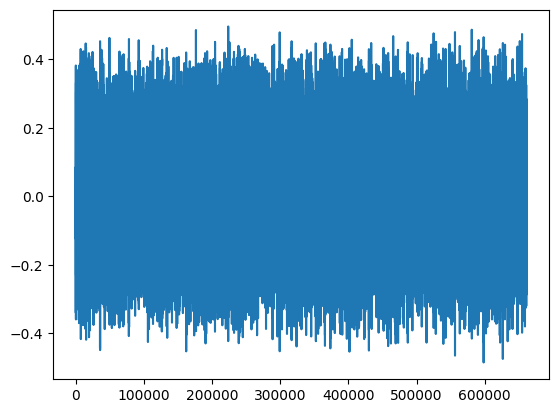

In [7]:
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0 # uint16 max
plt.plot(tensor.numpy())

Add a [fade](https://www.tensorflow.org/io/tutorials/audio)

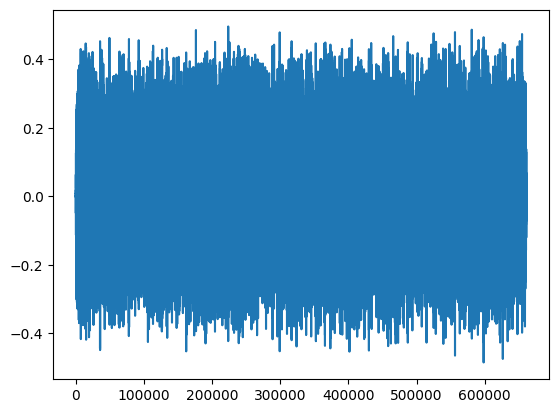

In [8]:
fade = tfio.audio.fade(
    tensor, fade_in=1000, fade_out=2000, mode="logarithmic"
)
plt.plot(fade.numpy())

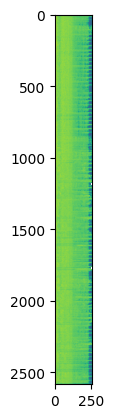

In [9]:
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256
)

plt.imshow(tf.math.log(spectrogram).numpy())

--- 

Now lets do the processing that MELGAN-VC does

In [10]:
# spectrogram stuff
hops = 192 # parameterizes fft
sr = 16000 # sampling rate

# db normalization
min_db = -100 # TODO: what did they want from this???
max_db = 120
ref_db = 20 # TODO: what did they want from this???

In [11]:
def normalize(S):
    return np.clip((((S - min_db) / -min_db)*2.)-1., -1, 1)

def process_sample(wav_file):
    audio = tfio.audio.AudioIOTensor(wav_file)
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)

    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0 # uint16 max
    spectrogram = tfio.audio.spectrogram(
        tensor,
        nfft=6*hops,
        window=6*hops,
        stride=hops
    )
    
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(
        spectrogram, 
        rate=sr, 
        mels=hops,
        fmin=0, 
        fmax=sr // 2
    )

#     # Convert to db scale mel-spectrogram
#     dbscale_mel_spectrogram = tfio.audio.dbscale(
#         mel_spectrogram, 
#         top_db=max_db
#     )
    
    # center on ref level
    dbscale_mel_spectrogram = mel_spectrogram - ref_db
    
    # normalize
    dbscale_mel_spectrogram = normalize(dbscale_mel_spectrogram)
    
    return audio_tensor, dbscale_mel_spectrogram

**TODO**

- [ ] Finish process sample (preprocessing necessary for going from wav --> spectrogram)
- [ ] Fully process metal + jazz genres
- [ ] EDa


EDA Ideas
* Sample length
* Clustering of samples
* ???

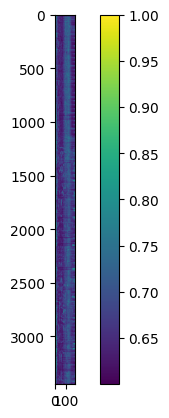

In [12]:
a, s = process_sample(os.path.join(data_dir, 'metal', 'metal.00000.wav'))

plt.imshow(s)
plt.colorbar()

In [35]:
files = []
waves = []
spectrograms = []

metal = os.path.join(data_dir,'metal')
for file in os.listdir(metal)[:20]:
    if '.' != file[0]:
        print(file)
        at, dms = process_sample(os.path.join(metal, file))
        
        files.append(file)
        waves.append(at)
        spectrograms.append(dms)

metal.00022.wav
metal.00036.wav
metal.00037.wav
metal.00023.wav
metal.00009.wav
metal.00035.wav
metal.00021.wav
metal.00020.wav
metal.00034.wav
metal.00008.wav


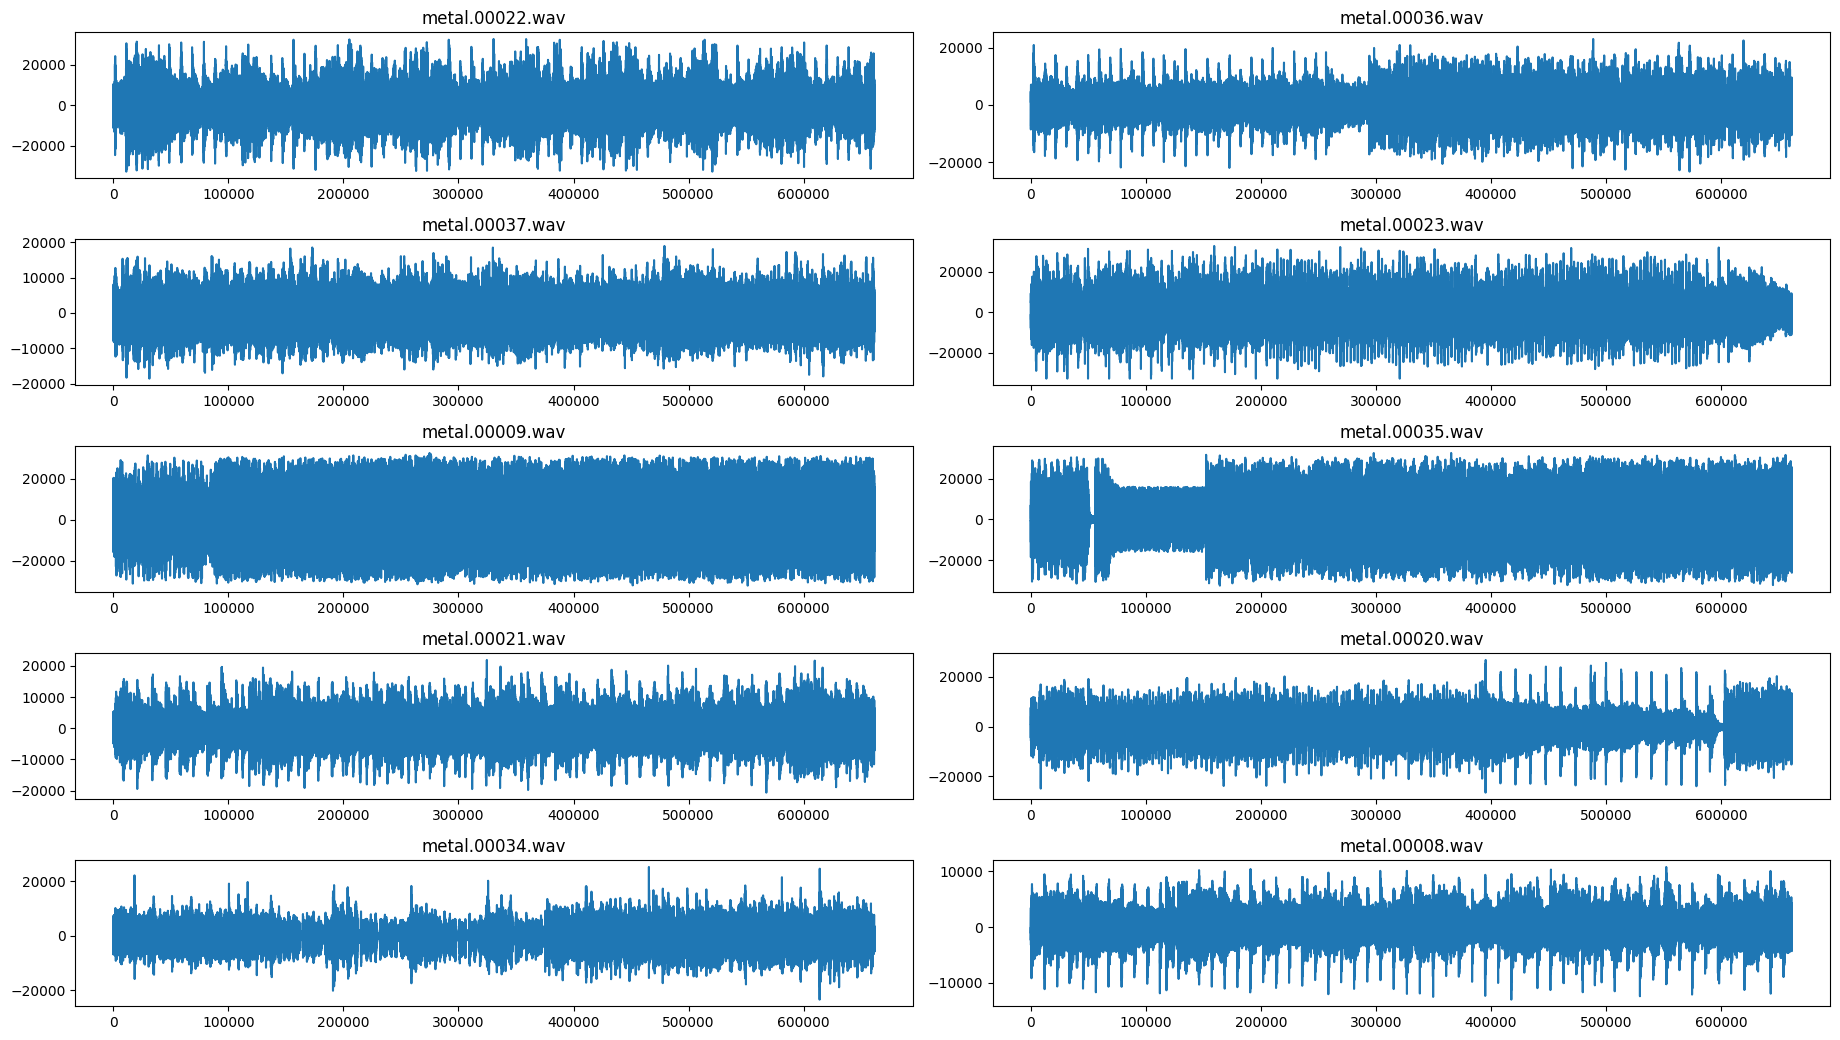

In [36]:
fig, axs = plt.subplots(len(waves) // 2, 2)
fig.set_size_inches(18.5, 10.5)

for file, wave, ax in zip(files, waves, axs.ravel()):
    ax.set_title(file)
    ax.plot(wave.numpy())

plt.tight_layout()

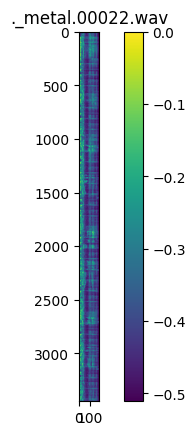

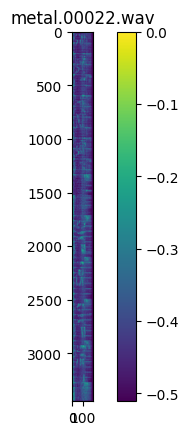

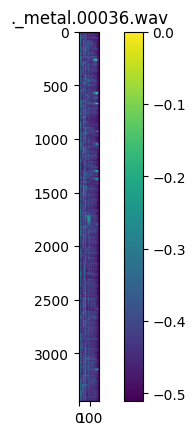

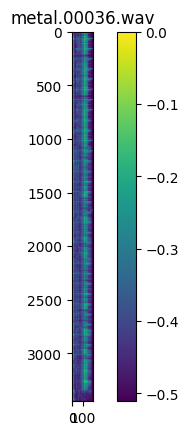

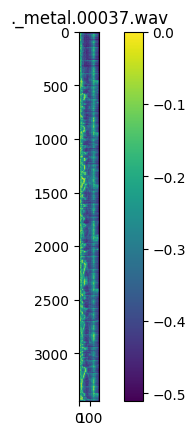

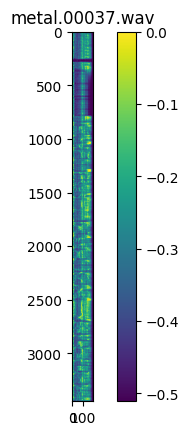

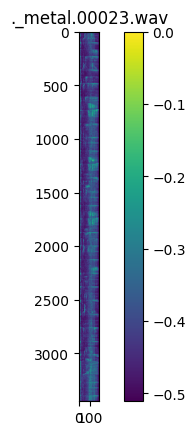

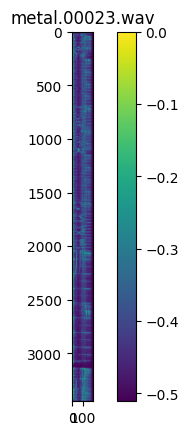

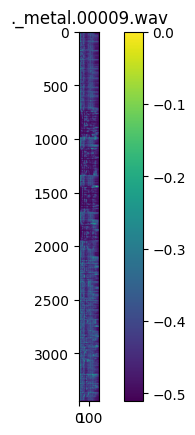

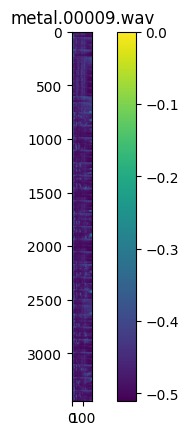

In [30]:
for file, spectrogram in zip(files, spectrograms):
    plt.figure()
    plt.title(file)
    plt.imshow(tf.math.log(spectrogram).numpy())
    plt.colorbar()


---

In [93]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [38]:
metal = os.path.join(data_dir,'metal')
jazz = os.path.join(data_dir, 'jazz')

In [51]:
def extract_spectrograms(_dir):
    spectrograms = []
    for file in tqdm(os.listdir(_dir)):
        try:
            if '.' != file[0]:
                _, spectrogram = process_sample(os.path.join(_dir, file))
                spectrograms.append(spectrogram)
        except Exception as err:
            pass
    return spectrograms

In [52]:
metal_spectrograms = extract_spectrograms(metal)
jazz_spectrograms = extract_spectrograms(jazz)

100%|██████████| 200/200 [00:03<00:00, 51.66it/s]


NOTE: jazz 0054 is malformed :(

In [59]:
len(metal_spectrograms), metal_spectrograms[0].shape

(100, (3446, 192))

In [68]:
len(metal_spectrograms), len(jazz_spectrograms), len(metal_spectrograms + jazz_spectrograms)

(100, 99, 199)

In [81]:
from tensorflow.keras.utils import pad_sequences

X = np.stack(
    pad_sequences(
        metal_spectrograms + jazz_spectrograms
    )
)

In [82]:
flat_X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
flat_X.shape

(199, 672192)

In [84]:
tsne = TSNE()

tsne_X = tsne.fit_transform(flat_X)

In [94]:
pca = PCA()
pca_X = pca.fit_transform(flat_X)

<BarContainer object of 199 artists>

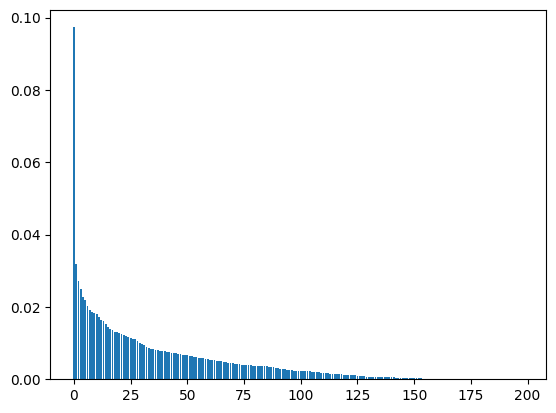

In [99]:
plt.bar(np.arange(pca.components_.shape[0]), pca.explained_variance_ratio_)

In [88]:
y = (['metal'] * len(metal_spectrograms)) + (['jazz'] * len(jazz_spectrograms))

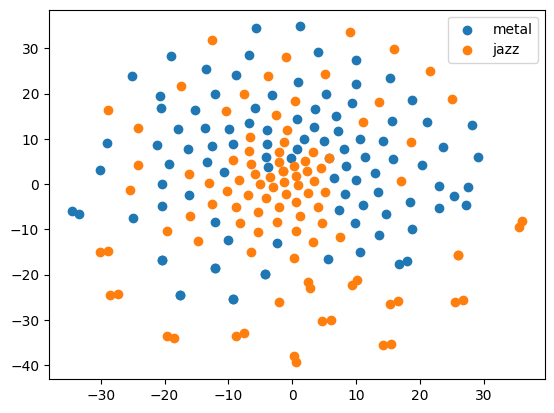

In [91]:
plt.scatter(tsne_X[:len(metal_spectrograms),0],
            tsne_X[:len(metal_spectrograms),1],
            label='metal')

plt.scatter(tsne_X[len(jazz_spectrograms):,0],
            tsne_X[len(jazz_spectrograms):,1],
            label='jazz')
plt.legend()

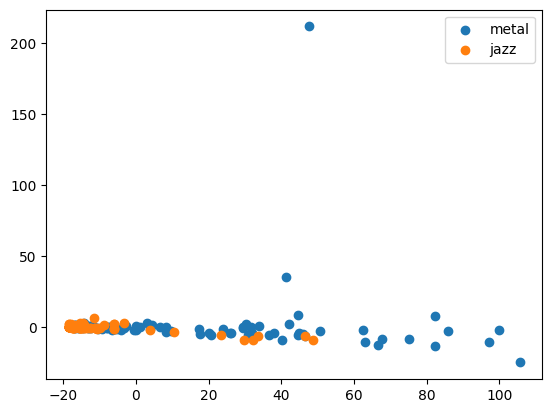

In [100]:
plt.scatter(pca_X[:len(metal_spectrograms),0],
            pca_X[:len(metal_spectrograms),1],
            label='metal')

plt.scatter(pca_X[len(jazz_spectrograms):,0],
            pca_X[len(jazz_spectrograms):,1],
            label='jazz')
plt.legend()